In [46]:
import os
import datetime
import pandas as pd
from pandas import json_normalize
import numpy as np
import re
import json
import requests
import time
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import pprint
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from nltk.corpus import stopwords


In [2]:
# subdue warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
sw = stopwords.words("english")

recipe_based_stopwords = ['teaspoon', 'tablespoon', 'fluid ounce',
                          'cup', 'pint', 'quart', 'gallon', 'milliliter',
                          'liter', 'gram', 'kilogram', 'ounce', 'pound', 
                          'pinch', 'dash', 'recipe', 'recipes', 'tin', 'tbsp',
                          'tablespoons', 'chopped', 'cups','oz.','teaspoons','finely',
                          'minced','taste','cut','tsp','&']

#len(recipe_based_stopwords)
#recipe_based_stopwords[10]

for rbs in recipe_based_stopwords:
    sw.append(rbs)

In [4]:
# define functions

punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation


def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    
    num_tokens=len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        counter = Counter(tokens)
        top_5_tokens = counter.most_common(5)
        print("Top 5 most common tokens:")
        for token, count in top_5_tokens:
            print(f"{token}: {count} occurrences")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


def remove_stopwords(tokens) :
    return [token for token in tokens if token not in sw]
    return(tokens)

def remove_punctuation(text, punct_set=tw_punct) :
    """
        Function takes two arguments: (1) text, which is the input string, and (2) the punctuation set, which is set to the tw_punct value set.
        Returns all characters not found in the punctuation set and concatenates them back into a string using the .join() method with an empty
        string "" as the separator.
    """
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """
        Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter.
    """
    tokens = text.split()
    return(tokens)

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [5]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=sw):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words_ingredients(df, column='Ingredients_tokens', preprocess=None, min_freq=2):

# process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

def count_words_title(df, column='Recipe_tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)



In [6]:
# data import
recipes = pd.read_csv("all_recipes.csv")
recipes.head(5)

,Recipe,URL,Ingredients
0,Michela’s tuna with cannellini beans (no cook),http://www.jamieoliver.com/recipes/fish-recipe...,1 x 400 g tin of cannellini beans\n1 x 80 g ti...
1,Haddock with cannellini beans & artichokes,https://www.bbcgoodfood.com/recipes/haddock-ca...,"400g can cannellini beans , drained and rinsed..."
2,Grilled Bruschetta - Cannellini Beans with Fet...,https://food52.com/recipes/10069-grilled-brusc...,1 loaf bread\n1 15 oz. can cannellini beans\n8...
3,Escarole with Cannellini Beans,https://www.epicurious.com/recipes/food/views/...,"1 sweet onion, halved\n1 head of garlic, halve..."
4,Broccoli Rabe with Cannellini Beans,http://www.eatingwell.com/recipe/255758/brocco...,"1 bunch broccoli rabe (1-1¼ pounds), trimmed a..."


In [7]:
#regex = For all numbers, single letters, numbers + single letters
import re

# Function to remove numbers, single letters, and numbers + single letters
def remove_patterns(text):
    pattern = r'(\b(?:\d+|\b\w\b|\d+\s*\w)\b)|[/\n%()]'
    #(\b(?:\d+|\b\w\b|\d+\s*\w)\b)|\n'
    return re.sub(pattern, '', text)

# Apply the function to the DataFrame column
recipes['Ingredients'] = recipes['Ingredients'].apply(remove_patterns)

# Remove line separators
#recipes['Ingredients'] = recipes['Ingredients'].replace('\n', '')

recipes.head(5)


,Recipe,URL,Ingredients
0,Michela’s tuna with cannellini beans (no cook),http://www.jamieoliver.com/recipes/fish-recipe...,tin of cannellini beans tin of tuna in ...
1,Haddock with cannellini beans & artichokes,https://www.bbcgoodfood.com/recipes/haddock-ca...,"can cannellini beans , drained and rinsed sma..."
2,Grilled Bruschetta - Cannellini Beans with Fet...,https://food52.com/recipes/10069-grilled-brusc...,loaf bread oz. can cannellini beans ounces f...
3,Escarole with Cannellini Beans,https://www.epicurious.com/recipes/food/views/...,"sweet onion, halved head of garlic, halved cr..."
4,Broccoli Rabe with Cannellini Beans,http://www.eatingwell.com/recipe/255758/brocco...,"bunch broccoli rabe - pounds, trimmed and coa..."


In [8]:
# store tokens in new dataframe 'df'
df=pd.DataFrame()

# fold to lowercase
df['Recipe_tokens']=recipes['Recipe'].str.lower()
df['Ingredients_tokens']=recipes['Ingredients'].str.lower()
#df['URL_tokens']=recipes['URL'].str.lower()

# remove punctuation
#df['Ingredients_tokens']=df['Ingredients_tokens'].apply(remove_punctuation)
#df['URL_tokens']=df['URL_tokens'].apply(remove_punctuation)
#df['Recipe_tokens']=df['Recipe_tokens'].apply(remove_punctuation)

# tokenize
df['Recipe_tokens']=tokenize(df['Recipe_tokens'].str)
df['Ingredients_tokens']=tokenize(df['Ingredients_tokens'].str)
#df['URL_tokens']=tokenize(df['URL_tokens'].str)

# remove stopwords
df['Ingredients_tokens']=df['Ingredients_tokens'].apply(remove_stopwords)
#df['URL_tokens']=df['URL_tokens'].apply(remove_stopwords)
df['Recipe_tokens']=df['Recipe_tokens'].apply(remove_stopwords)

df

,Recipe_tokens,Ingredients_tokens
0,"[michela’s, tuna, cannellini, beans, (no, cook)]","[cannellini, beans, tuna, spring, water, added..."
1,"[haddock, cannellini, beans, artichokes]","[cannellini, beans, ,, drained, rinsed, small,..."
2,"[grilled, bruschetta, -, cannellini, beans, fe...","[loaf, bread, cannellini, beans, ounces, feta,..."
3,"[escarole, cannellini, beans]","[sweet, onion,, halved, head, garlic,, halved,..."
4,"[broccoli, rabe, cannellini, beans]","[bunch, broccoli, rabe, -, pounds,, trimmed, c..."
...,...,...
1059,"[creamy, yogurt, porridge]","[porridge, oat, pot, fat, probiotic, yogurt]"
1060,"[twice-baked, truffled, potatoes-, appetizer]","[uniformly, sized, fingerling, potatoes, asiag..."
1061,"[frozen, strawberry, yogurt]","[strawberries, light, condensed, milk, tub, -f..."
1062,"[blueberry, honey, yogurt, parfait]","[plain, greek, yogurt, blueberries, sliced, al..."


In [9]:
Recipe_combined_tokens = [token for sublist in df['Ingredients_tokens'] for token in sublist]
descriptive_stats(Recipe_combined_tokens)

There are 19169 tokens in the data.
There are 2799 unique tokens in the data.
There are 116342 characters in the data.
The lexical diversity is 0.146 in the data.
Top 5 most common tokens:
salt: 440 occurrences
oil: 396 occurrences
pepper: 347 occurrences
fresh: 332 occurrences
olive: 315 occurrences


[19169, 2799, 0.1460170066252804, 116342]

In [10]:
title_combined_tokens = [token for sublist in df['Recipe_tokens'] for token in sublist]
descriptive_stats(title_combined_tokens)

There are 3444 tokens in the data.
There are 958 unique tokens in the data.
There are 21570 characters in the data.
The lexical diversity is 0.278 in the data.
Top 5 most common tokens:
chicken: 54 occurrences
roasted: 51 occurrences
oil: 48 occurrences
beans: 47 occurrences
pepper: 44 occurrences


[3444, 958, 0.2781649245063879, 21570]

In [11]:
# Count Vectorizer
count_title_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.7)
count_title_vectors = count_title_vectorizer.fit_transform(title_combined_tokens)
count_title_vectors.shape


(3444, 171)

In [12]:
# TF-IDF Vectorizer
tfidf_title_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_title_vectors = tfidf_title_vectorizer.fit_transform(title_combined_tokens)
tfidf_title_vectors.shape

(3444, 171)

In [13]:
# NFM Model
nmf_title_model = NMF(n_components=5, random_state=314)
W_title_matrix = nmf_title_model.fit_transform(tfidf_title_vectors)
H_title_matrix = nmf_title_model.components_

# Display NMF Model
display_topics(nmf_title_model, tfidf_title_vectorizer.get_feature_names_out())



Topic 00
  roasted (91.23)
  garlic (2.18)
  soy (2.15)
  sesame (1.36)
  thyme (1.02)

Topic 01
  chicken (97.56)
  grilled (2.44)
  rice (0.00)
  lemon (0.00)
  soup (0.00)

Topic 02
  beans (99.99)
  soup (0.01)
  rice (0.01)
  cauliflower (0.00)
  yogurt (0.00)

Topic 03
  pepper (84.58)
  red (10.38)
  lemon (3.09)
  hot (0.89)
  cucumber (0.87)

Topic 04
  oil (93.65)
  olive (5.10)
  fried (1.24)
  lemon (0.00)
  rice (0.00)


In [14]:
# Fitting LDA Model
lda_title_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_title_matrix = lda_title_model.fit_transform(count_title_vectors)
H_lda_title_matrix = lda_title_model.components_

# Display LDA Model
display_topics(lda_title_model, count_title_vectorizer.get_feature_names_out())


Topic 00
  pepper (8.91)
  beans (8.42)
  rice (6.61)
  soup (6.45)
  garlic (6.28)

Topic 01
  chicken (10.18)
  yogurt (6.92)
  salad (5.83)
  cheese (4.38)
  seeds (4.20)

Topic 02
  oil (10.50)
  red (8.08)
  grilled (7.28)
  olive (6.68)
  beef (5.87)

Topic 03
  roasted (11.99)
  cream (6.61)
  salt (5.42)
  chickpeas (4.82)
  lentils (3.82)

Topic 04
  lemon (8.34)
  green (6.06)
  sauce (5.64)
  sesame (4.81)
  mustard (4.60)


In [15]:
lda_display = pyLDAvis.lda_model.prepare(lda_title_model, count_title_vectors, count_title_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.cor

In [16]:
# Fitting LSA Model
svd_title_model = TruncatedSVD(n_components=5, random_state=314)
W_svd_title_matrix = svd_title_model.fit_transform(tfidf_title_vectors)
H_svd_title_matrix = svd_title_model.components_
# Display LSA Model
display_topics(svd_title_model, tfidf_title_vectorizer.get_feature_names_out())


Topic 00
  roasted (97.11)
  garlic (2.69)
  soy (2.31)
  soup (1.97)
  sesame (1.50)

Topic 01
  chicken (92.61)
  rice (2.07)
  cauliflower (1.17)
  lemon (1.16)
  soup (1.12)

Topic 02
  beans (96.39)
  soup (3.29)
  rice (2.88)
  cauliflower (2.55)
  sauce (2.14)

Topic 03
  pepper (60.57)
  oil (33.51)
  red (4.37)
  beans (2.75)
  soup (1.98)

Topic 04
  oil (195.87)
  olive (11.64)
  lemon (8.90)
  cauliflower (5.77)
  rice (3.69)


Wordcloud for Ingredients


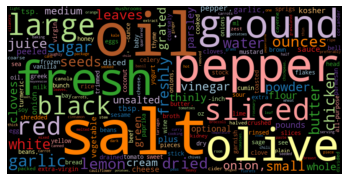

In [17]:
ingredient_count= count_words_ingredients(df)
print('Wordcloud for Ingredients')
wordcloud(ingredient_count['freq'])


Wordcloud for Recipe Titles


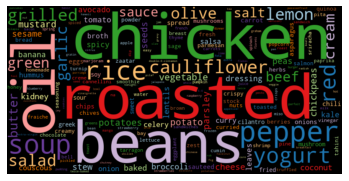

In [18]:
title_count=count_words_title(df)
print('Wordcloud for Recipe Titles')
wordcloud(title_count['freq'])

### Modeling

### LDA w/ Gensim 


In [22]:
# tokens stored in df['Recipe_tokens']
gensim_tokens = df['Recipe_tokens']

# initialize Gensim dictionary 
from gensim.corpora import Dictionary
dict_gensim = Dictionary(gensim_tokens)

# filter for words that appear in: at least 5 recipes, but not more than 70% of all recipes
dict_gensim.filter_extremes(no_below=5, no_above=0.7)

# calculate bag of words matrix
bow_gensim = [dict_gensim.doc2bow(token) for token in gensim_tokens]

# perform TF-IDF transformation
from gensim.models import TfidfModel
tfidf_gensim = TfidfModel(bow_gensim)
vectors_gensim = tfidf_gensim[bow_gensim]

In [23]:
# using LDA with Gensim
from gensim.models import LdaModel
lda_gensim = LdaModel (corpus = bow_gensim,
                       id2word = dict_gensim,
                       chunksize = 2000,
                       alpha = 'auto',
                       eta = 'auto',
                       iterations = 400,
                       num_topics = 5,
                       passes = 20,
                       eval_every = None,
                       random_state = 509)

In [25]:
# calculate coherence scores
from gensim.models.coherencemodel import CoherenceModel
lda_gensim_coherence = CoherenceModel(model = lda_gensim,
                                      texts = gensim_tokens,
                                      dictionary = dict_gensim,
                                      coherence = 'c_v')
lda_gensim_coherence_score = lda_gensim_coherence.get_coherence()
print(lda_gensim_coherence_score)

/opt/miniconda3/envs/ADS500B/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/miniconda3/envs/ADS500B/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/miniconda3/envs/ADS500B/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.6574343783058999


c_v coherence scoring is from 0-1, so the higher the score, the better.

In [26]:
# average coherence for all topics
top_topics = lda_gensim.top_topics(vectors_gensim, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -16.7786.


In [27]:
# get topic coherence scores along with most important words
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-6.898845874941173, 'roasted chicken red cauliflower pepper'),
 (-17.71763101520831, 'rice beans green vegetable couscous'),
 (-17.725052823741827, 'soup cream salad beef potato'),
 (-19.760817049634753, 'lemon yogurt salt pepper banana'),
 (-21.79047053323503, 'oil olive butter chickpeas cheese')]

In [104]:
# get topic probabilites for each recipe
topic_probabilities = [lda_gensim.get_document_topics(item) for item in bow_gensim]

# see example output
topic_probabilities[0]

[(0, 0.069617294),
 (1, 0.76808095),
 (2, 0.04583999),
 (3, 0.067112684),
 (4, 0.049349133)]

### Classification

In [45]:
# extract highest probability and add to dataframe
for i, row in enumerate(topic_probabilities):
    max_index = max(row, key=lambda x: x[1])[0]
    df.at[i, 'topic'] = max_index

# see topic distribution
df['topic'].value_counts()

topic
0.0    316
3.0    249
1.0    218
4.0    153
2.0    128
Name: count, dtype: int64

In [124]:
# see word distribution of topics
#display_topics_gensim(lda_gensim)
lda_gensim_topics = lda_gensim.show_topics(num_topics=5, num_words=10)

# Display the topics
for topic_idx, topic in lda_gensim_topics:
    print(f"Topic #{topic_idx + 1}: {topic}")

Topic #1: 0.083*"roasted" + 0.069*"chicken" + 0.059*"red" + 0.053*"cauliflower" + 0.041*"pepper" + 0.036*"seeds" + 0.035*"mustard" + 0.026*"parsley" + 0.026*"leaves" + 0.025*"salsa"
Topic #2: 0.057*"soup" + 0.057*"cream" + 0.055*"salad" + 0.055*"beef" + 0.043*"potato" + 0.039*"stew" + 0.036*"baked" + 0.033*"beans" + 0.032*"dressing" + 0.028*"hummus"
Topic #3: 0.094*"lemon" + 0.081*"yogurt" + 0.079*"salt" + 0.056*"pepper" + 0.047*"banana" + 0.047*"kale" + 0.044*"celery" + 0.032*"parmesan" + 0.029*"tarragon" + 0.029*"zest"
Topic #4: 0.082*"oil" + 0.057*"olive" + 0.046*"butter" + 0.045*"chickpeas" + 0.037*"cheese" + 0.037*"sauce" + 0.033*"coconut" + 0.032*"garlic" + 0.030*"avocado" + 0.027*"lentils"
Topic #5: 0.098*"rice" + 0.078*"beans" + 0.075*"green" + 0.062*"vegetable" + 0.039*"couscous" + 0.036*"potatoes" + 0.034*"spread" + 0.032*"kidney" + 0.029*"stock" + 0.029*"chives"


Wordcloud for Topic 


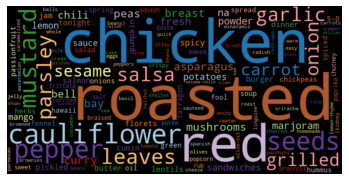

In [123]:
## visualize each topic 
topic0_count= count_words_title(df[df['topic']==0])
print('Wordcloud for Topic ')
wordcloud(topic0_count['freq'])

Wordcloud for Topic 1


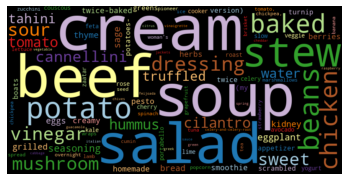

In [119]:
## visualize each topic 
topic1_count= count_words_title(df[df['topic']==1])
print('Wordcloud for Topic 1')
wordcloud(topic1_count['freq'])


Wordcloud for Topic 2


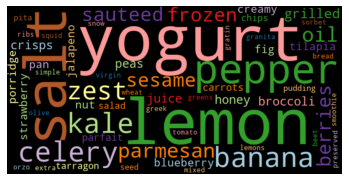

In [120]:
## visualize each topic 
topic2_count= count_words_title(df[df['topic']==2])
print('Wordcloud for Topic 2')
wordcloud(topic2_count['freq'])


Wordcloud for Topic 3


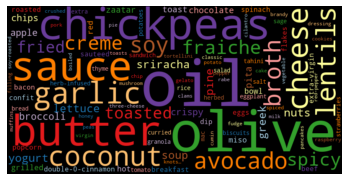

In [121]:
## visualize each topic 
topic3_count= count_words_title(df[df['topic']==3])
print('Wordcloud for Topic 3')
wordcloud(topic3_count['freq'])


Wordcloud for Topic 4


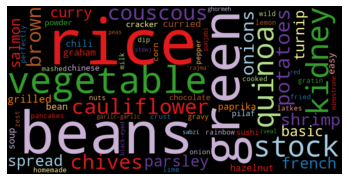

In [127]:
## visualize each topic 
topic4_count= count_words_title(df[df['topic']==4])
print('Wordcloud for Topic 4')
wordcloud(topic4_count['freq'])


**Topic 0:** Main dish w/ chicken 

**Topic 1:** Main dish w/ meat

**Topic 2:** Desserts/Sweets/

**Topic 3:** Sauces/sides/appetizers

**Topic 4:** Salads

In [93]:
# convert tfidf vectors into numpy array to be used
# as features in classification model

# Determine the number of features (maximum index + 1)
num_features = max(index for vector in vectors_gensim for index, _ in vector) + 1

# Create an empty NumPy array
features_array = np.zeros((len(vectors_gensim), num_features))

# Fill the array with TF-IDF values
for i, vector in enumerate(vectors_gensim):
    for index, value in vector:
        features_array[i, index] = value

print(features_array)

[[0.55570766 0.83137777 0.         ... 0.         0.         0.        ]
 [0.55570766 0.83137777 0.         ... 0.         0.         0.        ]
 [0.47478478 0.71031144 0.51965091 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.65583592]]


In [94]:
# data split 
X = features_array
y = df['topic']
train_x, test_x, train_y, test_y =train_test_split(X, y, test_size=0.20,
                            random_state=6,
                            shuffle=True,
                            stratify=df['topic'])

print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

851
851
213
213


In [95]:
# confirm stratified split--see topic distribution in training set
train_y.value_counts()

topic
0.0    253
3.0    199
1.0    174
4.0    122
2.0    103
Name: count, dtype: int64

#### Build classification models

In [96]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model on the training data
logreg.fit(train_x, train_y)

# Make predictions on the testing data
logreg_pred = logreg.predict(test_x)

# Evaluate the model
accuracy = accuracy_score(test_y, logreg_pred)
conf_matrix = confusion_matrix(test_y, logreg_pred)
classification_rep = classification_report(test_y, logreg_pred)

# Print the results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.892018779342723

Confusion Matrix:
[[58  1  1  2  1]
 [ 0 40  1  0  3]
 [ 2  1 21  1  0]
 [ 1  1  0 48  0]
 [ 3  1  1  3 23]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        63
         1.0       0.91      0.91      0.91        44
         2.0       0.88      0.84      0.86        25
         3.0       0.89      0.96      0.92        50
         4.0       0.85      0.74      0.79        31

    accuracy                           0.89       213
   macro avg       0.89      0.87      0.88       213
weighted avg       0.89      0.89      0.89       213



In [97]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(train_x, train_y)
dt_pred = model.predict(test_x)

accuracy = accuracy_score(test_y, dt_pred)
print("Decision Tree Accuracy:", accuracy)


Decision Tree Accuracy: 0.7887323943661971


In [99]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
rf_pred = rf_model.predict(test_x)

accuracy = accuracy_score(test_y, rf_pred)
print("Random Forest Accuracy:", accuracy)


Random Forest Accuracy: 0.8309859154929577


In [100]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(train_x, train_y)
svc_pred = svc_model.predict(test_x)

accuracy = accuracy_score(test_y, svc_pred)
print("SVM Accuracy:", accuracy)


SVM Accuracy: 0.8826291079812206


In [101]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(train_x, train_y)
knn_pred = knn_model.predict(test_x)

accuracy = accuracy_score(test_y, knn_pred)
print("KNN Accuracy:", accuracy)


KNN Accuracy: 0.8075117370892019


In [102]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(train_x, train_y)
nb_pred = nb_model.predict(test_x)

accuracy = accuracy_score(test_y, nb_pred)
print("Naive Bayes Accuracy:", accuracy)


Naive Bayes Accuracy: 0.8873239436619719
